In [1]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
from math import sqrt, pi
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values, state_to_return, pauli_to_int, int_to_pauli, basis_T_to_pauli,\
    reversed_str_bases_to_init_state, kernel_qaoa_Preserved, kernel_flipped, get_optimizer, optimizer_names, all_state_to_return, get_init_states

import time

cudaq.set_target("nvidia")

np.random.seed(42)

!! warning: Representing Pauli words using INTEGER !!

In [2]:
print(4**30 // 10**18)

1


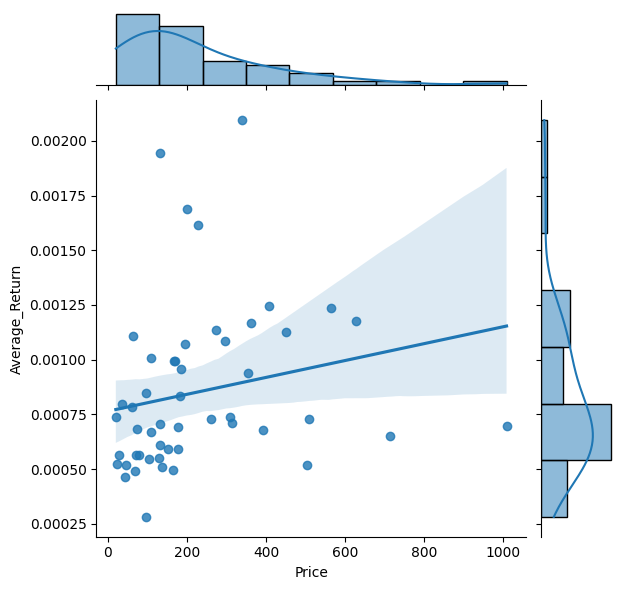

20.049999237060547 1008.5
0.0002817427940077 0.0020945858866767


In [3]:
import seaborn as sns
from copulas.multivariate import GaussianMultivariate
import joblib
data_cov = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_covariance.csv")
data_ret_p = pd.read_csv("../dataset/top_50_us_stocks_returns_price.csv")

data = data_ret_p.drop("Ticker", axis=1)
sns.jointplot(data=data, x='Price', y='Average_Return', kind='reg')
plt.show()

print(data["Price"].min(), data["Price"].max())
print(data["Average_Return"].min(), data["Average_Return"].max())

In [4]:
# X = data[['Price', 'Average_Return']]
# GM = GaussianMultivariate()
# GM.fit(X)
# joblib.dump(GM, './models/gaussian_copula.pkl')

0.00047935012980475784 0.0020720678257544305


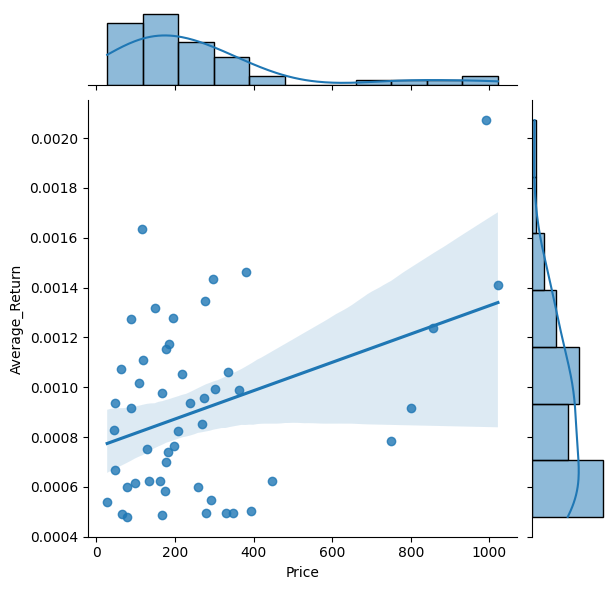

In [5]:
GM_loaded = joblib.load('./models/gaussian_copula.pkl')
samples = GM_loaded.sample(50)
print(samples["Average_Return"].min(), samples["Average_Return"].max())
sns.jointplot(data=samples, x='Price', y='Average_Return', kind='reg')
plt.show()

# HAMILTONIAN BY CUDAQ

### by random values

In [6]:
B = 100
ret = np.array([1.0, 1.25, 1.5])
cov = np.random.rand(3, 3)
cov += cov.T
print(cov)
P = np.array([100, 100, 100])
lamb = 0 # Budget Penalty
q = 0 # Volatility Weight

# P_b, ret_b, cov_b = po_normalize(B, P, ret, cov)
P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, P, ret, cov)

print("n_qubit:", n_qubit)
print("n_max:", n_max)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)

[[0.83482201 0.55972298 0.63865599]
 [0.55972298 1.88581941 1.02622189]
 [0.63865599 1.02622189 0.7272592 ]]
n_qubit: 3
n_max: [1 1 1]


In [7]:
print("Hamiltonian:", H)
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: (-0.5+0i) * I0 + (0.5+0i) * Z0 + (0+0i) + (-0.625+0i) * I1 + (0.625+0i) * Z1 + (-0.75+0i) * I2 + (0.75+0i) * Z2
[0, 1, 2]
[0.5, 0.625, 0.75]

[]
[]
[]


### by stock values

In [8]:
data_cov = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_covariance.csv")
data_ret_p = pd.read_csv("../dataset/top_50_us_stocks_returns_price.csv")

nn = 3
# B = 1500
B = 270
lamb = 0 # Budget Penalty
q = 0 # Volatility Weight

data_cov = data_cov.drop("Ticker", axis=1).iloc[:nn, :nn]
print(data_cov)
data_ret_p = data_ret_p.iloc[:nn]
# data_ret_p.loc[0, "Average_Return"] = 0.002070
# data_ret_p.loc[1, "Average_Return"] = 0.000050
# data_ret_p.loc[2, "Average_Return"] = 0.002070
print(data_ret_p)
stock_names = data_ret_p["Ticker"].tolist()
data_ret_p = data_ret_p.drop("Ticker", axis=1)

data_cov = data_cov.to_numpy()
data_ret_p = data_ret_p.to_numpy()

data_ret = data_ret_p[:, 0]
data_p = data_ret_p[:, 1]

# data_p = np.array([174.34238699, 111.28114309, 129.46979175])
# data_ret = np.array([0.00147772, 0.00097375, 0.00055953])
# B = 984.375

print(data_cov.shape)
print(data_ret.round(5))
print(data_p.round(2))
print(stock_names)

       AAPL      ABBV       ABT
0  0.000772  0.000078  0.000100
1  0.000078  0.000279  0.000103
2  0.000100  0.000103  0.000256
  Ticker  Average_Return       Price
0   AAPL        0.001070  195.270004
1   ABBV        0.000832  183.259995
2    ABT        0.000706  131.300003
(3, 3)
[0.00107 0.00083 0.00071]
[195.27 183.26 131.3 ]
['AAPL', 'ABBV', 'ABT']


In [9]:
P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, data_p, data_ret, data_cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb).canonicalize() * 500

n_qubit: 4


In [10]:
print("Hamiltonian:", H)
# print("H canonicalized:", H.canonicalize())
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: (-0.592249+0i) + (0.193536+0i) * Z0 + (0.141215+0i) * Z1 + (0.0858325+0i) * Z2 + (0.171665+0i) * Z3
[0, 1, 2, 3]
[0.19353621438596744, 0.1412153785790853, 0.08583247190085473, 0.17166494380170946]

[]
[]
[]


In [11]:
print(list(map(int, "0010")))

[0, 0, 1, 0]


In [12]:
# def state_to_return(s, B, C, d_ret, d_p):
#     l = np.array(list(map(int, s)))
#     P = d_p @ C
#     ret_C = (d_ret * d_p) @ C
#     ss = l @ ret_C
#     bud = l @ P
#     return ss, bud <= B

# ex_ret, in_budget = state_to_return("0001", B, C, data_ret, data_p)
# print(ex_ret, in_budget)

# CUDA QAOA

In [13]:
idx_1_use, coeff_1_use = idx_1, coeff_1
idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a, idx_2_b, coeff_2

# idx_1_use, coeff_1_use = idx_1_qis, coeff_1_qis
# idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a_qis, idx_2_b_qis, coeff_2_qis

In [14]:
print(H)
print(n_qubit)

(-0.592249+0i) + (0.193536+0i) * Z0 + (0.141215+0i) * Z1 + (0.0858325+0i) * Z2 + (0.171665+0i) * Z3
4


In [15]:
# bases = ["0001", "0010"]
# T = np.array([[0, 1], [1, 0]])
# mixer_s, mixer_c, A_all = basis_T_to_pauli(bases, T, len(bases[0]))
# print(f"{mixer_s}\n{mixer_c}")

# print(A_all.to_matrix())

# # AA_all = A_all.copy()
# AA_all = 0.25 * spin.x(0) * spin.x(2) + 0.25 * spin.x(0) * spin.z(1) * spin.x(2) \
#        + 0.25 * spin.y(0) * spin.y(2) + 0.25 * spin.y(0) * spin.z(1) * spin.y(2)
# print(AA_all.to_matrix())

In [16]:
# init_bases = ["100", "010", "001"]
# T = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])

init_bases = ["1000", "0100", "0001"]
# init_bases = ["100000", "010000", "000100"]
T = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])

mixer_s, mixer_c = basis_T_to_pauli(init_bases, T, n_qubit)

print(f"{mixer_s}\n{mixer_c}")
init_bases = reversed_str_bases_to_init_state(init_bases, n_qubit)
print("init_bases:", abs(init_bases))

# state_return, in_budget = all_state_to_return(B, C, data_ret, data_p, 1.0)
# init_state = get_init_states(state_return, in_budget, 0.02, n_qubit)
# # init_state = get_init_states(state_return, in_budget, 0.2, n_qubit)
# n_bases = len(init_state)
# print("n_bases:", n_bases)
# # print(init_state)
# T = np.zeros((n_bases, n_bases), dtype=np.float32)
# T[:-1, 1:] += np.eye(n_bases - 1, dtype=np.float32)
# T[1:, :-1] += np.eye(n_bases - 1, dtype=np.float32)
# T[0, -1] = T[-1, 0] = 1.0
# print(T)
# mixer_s, mixer_c = basis_T_to_pauli(init_state, T, n_qubit)
# # mixer_c *= 100
# init_bases = reversed_str_bases_to_init_state(init_state, n_qubit)
# # print(f"{mixer_s}\n{mixer_c}")
# print(mixer_c[0])
# print("init_bases:", abs(init_bases))

['XXII', 'XXIZ', 'XXZI', 'XXZZ', 'YYII', 'YYIZ', 'YYZI', 'YYZZ', 'XIIX', 'XIZX', 'XZIX', 'XZZX', 'YIIY', 'YIZY', 'YZIY', 'YZZY', 'IXIX', 'IXZX', 'ZXIX', 'ZXZX', 'IYIY', 'IYZY', 'ZYIY', 'ZYZY']
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125
 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
init_bases: [0.         0.57735026 0.57735026 0.         0.         0.
 0.         0.         0.57735026 0.         0.         0.
 0.         0.         0.         0.        ]


In [17]:
print(mixer_s[:2])
print(mixer_c[:2])
print(coeff_1_use)

['XXII', 'XXIZ']
[0.125 0.125]
[0.19353621438596744, 0.1412153785790853, 0.08583247190085473, 0.17166494380170946]


In [30]:
a = "AB"
for i, c in enumerate(a):
    print(i, c)
print()
for i, c in reversed(list(enumerate(a[:-1]))):
    print(i, c)

0 A
1 B

0 A


In [19]:
def nplize(a):
    for i in range(len(a)):
        a[i] = np.array(a[i])
    return a

In [20]:
a = [[1, 2, np.array(3)], [1, 2, np.array(3)]]
print(nplize(a))
a = [1, 2, np.array(3)]
b = [*a]
print(b)

[array([1, 2, 3]), array([1, 2, 3])]
[1, 2, array(3)]


In [54]:
def prepare_preserving_ansatz(qubit_count: int, idx_1: List[int], coeff_1: List[float], idx_2_a: List[int], idx_2_b: List[int], coeff_2: List[float], mixer_str: List[cudaq.pauli_word], mixer_coeff: List[float]):
    def generate_list():
        return [[] for _ in range(qubit_count)]
    type_l, zeta_l, entang_l, runnum_l = [generate_list() for _ in range(4)]
    cou = 0
    all_gate, mk = [], []
    def remove(idx):
        tp = type_l[idx].pop()
        zt = zeta_l[idx].pop()
        et = entang_l[idx].pop()
        rn = runnum_l[idx].pop()
        mk[rn] = False
        # print("-", idx, rn, tp, zt, et)
    def add(typee, idx, zeta, idx_en):
        nonlocal cou
        # print("+", idx, cou, typee, zeta, idx_en)
        type_l[idx].append(typee)
        zeta_l[idx].append(zeta)
        entang_l[idx].append(idx_en)
        runnum_l[idx].append(cou)
        mk.append(typee != 5)
        all_gate.append([typee, idx, *zeta, idx_en])
        cou += 1
    def nplize(a):
        for i in range(len(a)):
            a[i] = np.array(a[i], dtype=np.float32)
        return a
    def is_zero(val, bound=1e-8):
        return abs(val) < bound
    def push(typee, idx, zeta=[0, 0, 0], idx_en=-1): # typee[0: RX, 1: RY, 2: RZ, 3: H, 4: CX-control, 5: CX-target], zeta: (const_coeff, problem_coeff, mixer_coeff)
        nonlocal cou
        # print("*", idx, cou, typee, zeta, idx_en)
        if len(type_l[idx]) > 0 and type_l[idx][-1] == typee:
            if typee <= 3:
                if not (is_zero(zeta_l[idx][-1][0] + zeta[0]) and is_zero(zeta_l[idx][-1][1] + zeta[1]) and is_zero(zeta_l[idx][-1][2] + zeta[2])):
                    for i in range(3):
                        zeta_l[idx][-1][i] += zeta[i]
                        all_gate[runnum_l[idx][-1]][i + 2] = zeta_l[idx][-1][i]
                    print("^", idx, runnum_l[idx][-1], typee, zeta_l[idx][-1])
                else:
                    remove(idx)
            if typee == 4:
                if len(entang_l[entang_l[idx][-1]]) > 0 and idx_en == entang_l[idx][-1] and idx == entang_l[entang_l[idx][-1]][-1]:
                    remove(idx)
                    remove(entang_l[idx][-1])
                else:
                    add(typee, idx, zeta, idx_en)
                    add(5, idx_en, [0, 0, 0], idx)
        else:
            add(typee, idx, zeta, idx_en)
            if typee == 4:
                add(5, idx_en, [0, 0, 0], idx)

            # print(idx)
    def push_pauli_string(strr, coeff):
        for i, p in enumerate(strr):
            if p == "X":
                push(3, i)
            elif p == "Y":
                push(0, i, [pi/2, 0, 0])
                # push(3, i)
        ll = -1
        for i, p in enumerate(strr):
            if p in ["X", "Y", "Z"]:
                if ll != -1:
                    push(4, ll, idx_en=i)
                    # push(5, i, idx_en=ll)
                ll = i
        push(2, ll, [0, 0, -2 * coeff])
        ll = -1
        for i, p in reversed(list(enumerate(strr))):
            if p in ["X", "Y", "Z"]:
                if ll != -1:
                    push(4, i, idx_en=ll)
                    # push(5, ll, idx_en=i)
                ll = i
        for i, p in enumerate(strr):
            if p == "X":
                push(3, i)
            elif p == "Y":
                # push(3, i)
                push(0, i, [-pi/2, 0, 0])
    
    for j in range(len(idx_1)):
        push(2, idx_1[j], [0, 2 * coeff_1[j], 0])
    for j in range(len(idx_2_a)):
        push(4, idx_2_a[j], idx_en=idx_2_b[j])
        # push(5, idx_2_b[j], idx_en=idx_2_a[j])
        push(2, idx_2_b[j], [0, 2 * coeff_2[j], 0])
        push(4, idx_2_a[j], idx_en=idx_2_b[j])
        # push(5, idx_2_b[j], idx_en=idx_2_a[j])
    for j in range(len(mixer_str)):
        push_pauli_string(mixer_str[j], mixer_coeff[j])

    # print(all_gate[6])
    return [nplize(i) for i in[type_l, zeta_l, entang_l, runnum_l]] + nplize([all_gate, mk])

type_l, zeta_l, entang_l, runnum_l, all_gate, mk = prepare_preserving_ansatz(n_qubit, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c.tolist())
# type_l, zeta_l, entang_l, runnum_l, all_gate, mk = prepare_preserving_ansatz(n_qubit, idx_1_use, coeff_1_use, [0], [1], [0.3], ["ZZII", "XXZI"], mixer_c[:2].tolist())
all_gate = all_gate[mk == 1].reshape(-1)

In [22]:
print(mk)

[1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 1.]


In [37]:
# print(len(all_gate), all_gate)
ag = all_gate.reshape(-1, 6)
al = [[] for _ in range(4)]
for i in range(len(ag)):
    al[int(ag[i][1])].append(ag[i])
# print(al)
for ii in range(len(al)):
    print(ii)
    for i in range(len(al[ii])):
        print(al[ii][i].tolist())
    print()

0
[2.0, 0.0, 0.0, 0.3870724141597748, 0.0, -1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[3.0, 0.0, 0.0, 0.0, 0.0, -1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[3.0, 0.0, 0.0, 0.0, 0.0, -1.0]

1
[2.0, 1.0, 0.0, 0.2824307680130005, 0.0, -1.0]
[2.0, 1.0, 0.0, 0.6000000238418579, -0.25, -1.0]
[3.0, 1.0, 0.0, 0.0, 0.0, -1.0]
[4.0, 1.0, 0.0, 0.0, 0.0, 3.0]
[4.0, 1.0, 0.0, 0.0, 0.0, 3.0]
[3.0, 1.0, 0.0, 0.0, 0.0, -1.0]

2
[2.0, 2.0, 0.0, 0.17166493833065033, 0.0, -1.0]

3
[2.0, 3.0, 0.0, 0.34332987666130066, 0.0, -1.0]
[2.0, 3.0, 0.0, 0.0, -0.25, -1.0]



In [38]:
for ii in range(len(type_l)):
    print(ii)
    for i in range(len(type_l[ii])):
        print(type_l[ii][i], zeta_l[ii][i].tolist(), entang_l[ii][i], runnum_l[ii][i])
    print()


0
2.0 [0.0, 0.3870724141597748, 0.0] -1.0 0.0
4.0 [0.0, 0.0, 0.0] 1.0 4.0
4.0 [0.0, 0.0, 0.0] 1.0 9.0
3.0 [0.0, 0.0, 0.0] -1.0 11.0
4.0 [0.0, 0.0, 0.0] 1.0 13.0
4.0 [0.0, 0.0, 0.0] 1.0 20.0
3.0 [0.0, 0.0, 0.0] -1.0 22.0

1
2.0 [0.0, 0.2824307680130005, 0.0] -1.0 1.0
5.0 [0.0, 0.0, 0.0] 0.0 5.0
2.0 [0.0, 0.6000000238418579, -0.25] -1.0 6.0
5.0 [0.0, 0.0, 0.0] 0.0 10.0
3.0 [0.0, 0.0, 0.0] -1.0 12.0
5.0 [0.0, 0.0, 0.0] 0.0 14.0
4.0 [0.0, 0.0, 0.0] 3.0 15.0
4.0 [0.0, 0.0, 0.0] 3.0 18.0
5.0 [0.0, 0.0, 0.0] 0.0 21.0
3.0 [0.0, 0.0, 0.0] -1.0 23.0

2
2.0 [0.0, 0.17166493833065033, 0.0] -1.0 2.0

3
2.0 [0.0, 0.34332987666130066, 0.0] -1.0 3.0
5.0 [0.0, 0.0, 0.0] 1.0 16.0
2.0 [0.0, 0.0, -0.25] -1.0 17.0
5.0 [0.0, 0.0, 0.0] 1.0 19.0



In [39]:
@cudaq.kernel
def kernel_cmpz_Preserved(thetas: List[float], qubit_count: int, layer_count: int, params: List[float]):
    qreg = cudaq.qvector(qubit_count)
    for i in range(layer_count):
        for j in range(len(params) // 6):
            # typee, idx, z1, z2, z3, idx_en = params[6*j:6*(j+1)]
            # zeta = z1 + z2 * thetas[i] + z3 * thetas[layer_count + i]
            # if typee in [0, 1, 2]: # RX, RY, RZ
            #     rx(zeta, qreg[int(idx)])
            # elif typee == 3: # H
            #     h(qreg[int(idx)])
            # elif typee == 4: # CX-control
            #     cx(qreg[int(idx)], qreg[int(idx_en)])

            typee = params[6 * j]
            idx = int(params[6 * j + 1])
            zeta = params[6*j+2] + thetas[i] * params[6*j+3] + thetas[i+layer_count] * params[6*j+4]
            if typee  == 0: # RX
                rx(zeta, qreg[idx])
            elif typee == 1: # RY
                ry(zeta, qreg[idx])
            elif typee == 2: # RZ
                rz(zeta, qreg[idx])
            elif typee == 3: # H
                h(qreg[idx])
            elif typee == 4: # CX-control
                cx(qreg[idx], qreg[int(params[6*j+5])])


In [43]:
print(cudaq.draw(kernel_qaoa_Preserved, [1.0]*4, n_qubit, 1, idx_1_use, coeff_1_use, [0], [1], [0.3], ["ZZII", "XXZI"], mixer_c[:2], init_bases))

     ╭────────────╮                                            ╭───╮          »
q0 : ┤ rz(0.3871) ├──●───────────────●────●─────────────────●──┤ h ├──●───────»
     ├────────────┤╭─┴─╮╭─────────╮╭─┴─╮╭─┴─╮╭───────────╮╭─┴─╮├───┤╭─┴─╮     »
q1 : ┤ rz(0.2824) ├┤ x ├┤ rz(0.6) ├┤ x ├┤ x ├┤ rz(-0.25) ├┤ x ├┤ h ├┤ x ├──●──»
     ├────────────┤╰───╯╰─────────╯╰───╯╰───╯╰───────────╯╰───╯╰───╯╰───╯╭─┴─╮»
q2 : ┤ rz(0.1717) ├──────────────────────────────────────────────────────┤ x ├»
     ├────────────┤                                                      ╰───╯»
q3 : ┤ rz(0.3433) ├───────────────────────────────────────────────────────────»
     ╰────────────╯                                                           »

################################################################################

                       ╭───╮
────────────────────●──┤ h ├
                  ╭─┴─╮├───┤
───────────────●──┤ x ├┤ h ├
╭───────────╮╭─┴─╮╰───╯╰───╯
┤ rz(-0.25) ├┤ x ├──────────
╰───────────╯╰───╯     

In [41]:
for i in ag:
    print(i.tolist())

[2.0, 0.0, 0.0, 0.3870724141597748, 0.0, -1.0]
[2.0, 1.0, 0.0, 0.2824307680130005, 0.0, -1.0]
[2.0, 2.0, 0.0, 0.17166493833065033, 0.0, -1.0]
[2.0, 3.0, 0.0, 0.34332987666130066, 0.0, -1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[2.0, 1.0, 0.0, 0.6000000238418579, -0.25, -1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[3.0, 0.0, 0.0, 0.0, 0.0, -1.0]
[3.0, 1.0, 0.0, 0.0, 0.0, -1.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[4.0, 1.0, 0.0, 0.0, 0.0, 3.0]
[2.0, 3.0, 0.0, 0.0, -0.25, -1.0]
[4.0, 1.0, 0.0, 0.0, 0.0, 3.0]
[4.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[3.0, 0.0, 0.0, 0.0, 0.0, -1.0]
[3.0, 1.0, 0.0, 0.0, 0.0, -1.0]


In [55]:
print(cudaq.draw(kernel_cmpz_Preserved, [1.0]*4, n_qubit, 1, all_gate))

     ╭────────────╮╭───╮                                              »
q0 : ┤ rz(0.3871) ├┤ h ├──●───────────────────────────────────────────»
     ├────────────┤├───┤╭─┴─╮╭───────────╮                            »
q1 : ┤ rz(0.2824) ├┤ h ├┤ x ├┤ rz(-0.25) ├──●─────────────────●────●──»
     ├────────────┤╰───╯╰───╯╰───────────╯  │                 │  ╭─┴─╮»
q2 : ┤ rz(0.1717) ├─────────────────────────┼─────────────────┼──┤ x ├»
     ├────────────┤                       ╭─┴─╮╭───────────╮╭─┴─╮╰───╯»
q3 : ┤ rz(0.3433) ├───────────────────────┤ x ├┤ rz(-0.25) ├┤ x ├─────»
     ╰────────────╯                       ╰───╯╰───────────╯╰───╯     »

################################################################################

                                              ╭───╮╭───────────╮     »
───────────────────────────────────────────●──┤ h ├┤ rx(1.571) ├──●──»
                                         ╭─┴─╮├───┤├───────────┤╭─┴─╮»
──────────────────────────────────────●──┤ x ├┤ h ├┤ rx(

In [51]:
print(mixer_s)

['XXII', 'XXIZ', 'XXZI', 'XXZZ', 'YYII', 'YYIZ', 'YYZI', 'YYZZ', 'XIIX', 'XIZX', 'XZIX', 'XZZX', 'YIIY', 'YIZY', 'YZIY', 'YZZY', 'IXIX', 'IXZX', 'ZXIX', 'ZXZX', 'IYIY', 'IYZY', 'ZYIY', 'ZYZY']


In [50]:
print(cudaq.draw(kernel_qaoa_Preserved, [1]*4, n_qubit, 1, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, init_bases))

     ╭────────────╮╭───╮                       ╭───╮╭───╮          »
q0 : ┤ rz(0.3871) ├┤ h ├──●─────────────────●──┤ h ├┤ h ├──●───────»
     ├────────────┤├───┤╭─┴─╮╭───────────╮╭─┴─╮├───┤├───┤╭─┴─╮     »
q1 : ┤ rz(0.2824) ├┤ h ├┤ x ├┤ rz(-0.25) ├┤ x ├┤ h ├┤ h ├┤ x ├──●──»
     ├────────────┤╰───╯╰───╯╰───────────╯╰───╯╰───╯╰───╯╰───╯  │  »
q2 : ┤ rz(0.1717) ├─────────────────────────────────────────────┼──»
     ├────────────┤                                           ╭─┴─╮»
q3 : ┤ rz(0.3433) ├───────────────────────────────────────────┤ x ├»
     ╰────────────╯                                           ╰───╯»

################################################################################

                       ╭───╮╭───╮                                 ╭───╮╭───╮»
────────────────────●──┤ h ├┤ h ├──●───────────────────────────●──┤ h ├┤ h ├»
                  ╭─┴─╮├───┤├───┤╭─┴─╮                       ╭─┴─╮├───┤├───┤»
───────────────●──┤ x ├┤ h ├┤ h ├┤ x ├──●─────────────────●──┤

# Ansatz Architecture

In [19]:
idx = 3
layer_count = 5

parameter_count = layer_count * 2
optimizer, optimizer_name, FIND_GRAD = get_optimizer(idx)

optimizer.max_iterations = 1000


optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, init_bases)

Initial parameters =  [0.3705367812928655, 0.36320525611565224, -0.19494972898149013, -0.0021610184187193515, -0.1563898097625048, -0.16898588055343988, -0.3637281409931357, 0.0860516266816756, 0.002104099923646907, -0.3522677650129884]


In [20]:
print(optimizer.episodes)

None


# Optimize

In [21]:
expectations = []

def cost_func(parameters):
    # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
    return cudaq.observe(kernel_qaoa_Preserved, H, parameters, *ansatz_fixed_param).expectation()

def objective(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)
    return expectation

def objective_grad_cuda(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)

    gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

    return expectation, gradient

objective_func = objective_grad_cuda if FIND_GRAD else objective
print("Required Gradient = ", FIND_GRAD)

Required Gradient =  True


In [22]:
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()

if not os.path.exists("./output_PO_mixer"):
    os.makedirs("./output_PO_mixer")
np.save(f"./output_PO_mixer/expectations_{optimizer_name}.npy", np.array(expectations))

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

optimal_expectation = -0.38152819299451957
optimal_parameters = [0.04531129988702345, 0.013504755321200438, -0.3384591513296177, -0.36064455875604157, -0.5474430630575421, -0.04548050202110984, -0.7943620056219682, 0.5428693557281368, 0.4243206620194912, -0.7532368227507288]
Time taken =  0.8798730373382568


In [23]:
shots_count = int(1e6)
print(f"Sampling {shots_count} times...")
# result = cudaq.sample(kernel_qaoa, int(n_qubit), layer_count, optimal_parameters, 0, shots_count=shots_count)
result = cudaq.sample(kernel_qaoa_Preserved, optimal_parameters, *ansatz_fixed_param, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**n_qubit - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(n_qubit)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
# print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)
print("|q0>|q1>|q2>...")



Sampling 1000000 times...
Finding the best solution...
1000 904380 0.90438
|q0>|q1>|q2>...


In [24]:
state = cudaq.get_state(kernel_qaoa_Preserved, optimal_parameters, *ansatz_fixed_param)
# print(state)

rows = []
col = ["State", "Probability", "Return", "In_Budget"]
ret_sum = 0
state_best, return_best = "", 0
state_high, return_high = result.most_probable(), 0
for i in range(len(state)):
    bb = bin(i)[2:].zfill(n_qubit)
    ret, in_bud = state_to_return(bb, B, C, data_ret, data_p)
    if in_bud and ret > return_best:
        state_best, return_best = bb, ret
    if state_high == bb:
        return_high = ret
    prob = abs(state[i])**2
    # print(prob, abs(state[i])**2)
    # print(bb, "\t", round(abs(state[i])**2, 4), "\t", round(ret, 4))
    al = np.array([bb, round(abs(state[i])**2, 4), round(ret, 4), in_bud])
    rows.append(al)
    ret_sum += ret * prob
    # print(al)

df = pd.DataFrame(rows, columns=col)
# print(df)
print("Expected Return:", round(ret_sum, 4))

colorr = ["blue" if in_bud == "True" else "red" for in_bud in df["In_Budget"]]
ex_ret = df["Return"].to_numpy()
# print(len(state))

print("Best state:", state_best, "Return:", return_best)
print("Most probable state:", state_high, "Return:", return_high)

Expected Return: 0.2061
Best state: 1000 Return: 0.20901911153684485
Most probable state: 1000 Return: 0.20901911153684485


In [25]:
print(np.array(state))

[ 0.0000000e+00+0.000000e+00j  8.8339585e-01-3.529584e-01j
  1.2617746e-01+7.533954e-02j  0.0000000e+00+0.000000e+00j
  0.0000000e+00+0.000000e+00j  0.0000000e+00+0.000000e+00j
  0.0000000e+00+0.000000e+00j  0.0000000e+00+0.000000e+00j
 -2.1154609e-01-1.693625e-01j  0.0000000e+00+0.000000e+00j
  0.0000000e+00+0.000000e+00j  1.9269319e-09+2.242715e-08j
  0.0000000e+00+0.000000e+00j  0.0000000e+00+0.000000e+00j
  0.0000000e+00+0.000000e+00j  0.0000000e+00+0.000000e+00j]


In [26]:
assert False

AssertionError: 

In [27]:
print(result)
print(np.abs(np.array(state))**2)

stt = cudaq.get_state(kernel_flipped, state, n_qubit)
print(np.abs(np.array(stt))**2)

{ 0001:73898 0100:21722 1000:904380 }

[0.0000000e+00 9.0496802e-01 2.1596797e-02 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 7.3435411e-02 0.0000000e+00
 0.0000000e+00 5.0669008e-16 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
[0.0000000e+00 7.3435411e-02 0.0000000e+00 0.0000000e+00 2.1596797e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.0496802e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0669008e-16 0.0000000e+00
 0.0000000e+00]


In [28]:
result_final = np.zeros(2**n_qubit)
for i in result:
    result_final[int(i, 2)] = result[i]

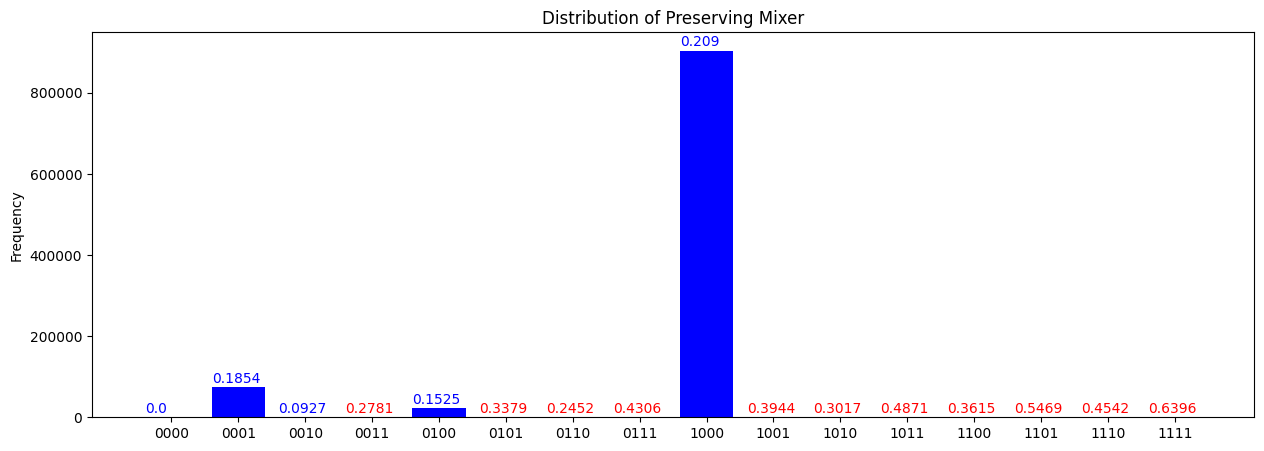

In [29]:
# plt.figure(figsize=(100, 15))
plt.figure(figsize=(15, 5))
x = np.arange(2**n_qubit)

# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**n_qubit), result_final, color=colorr)
# plt.bar(range(int(2**(n_qubit-3)*0.1)), result_final[2**(n_qubit-3)*4:int(2**(n_qubit-3)*4.1)])
plt.ylabel('Frequency')
plt.title('Distribution of Preserving Mixer')
# plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
# plt.xticks(xlocs, xlabs)
plt.xticks(x, [f"{i:0{n_qubit}b}" for i in x])
xlocs, xlabs = plt.xticks()
# print(xlocs, xlabs)
for i, s in enumerate(ex_ret):
    plt.text(xlocs[i]-0.4, result_final[i]+result_final[int(state_high, 2)]/80, s, color=colorr[i])

plt.show()

Exhaustive Search

x: qubit (100 samples per qubit)
y: approx ratio (best vs real best)

Expectations file not found for Nelder-Mead
Expectations file not found for COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Expectations file not found for GradientDescent


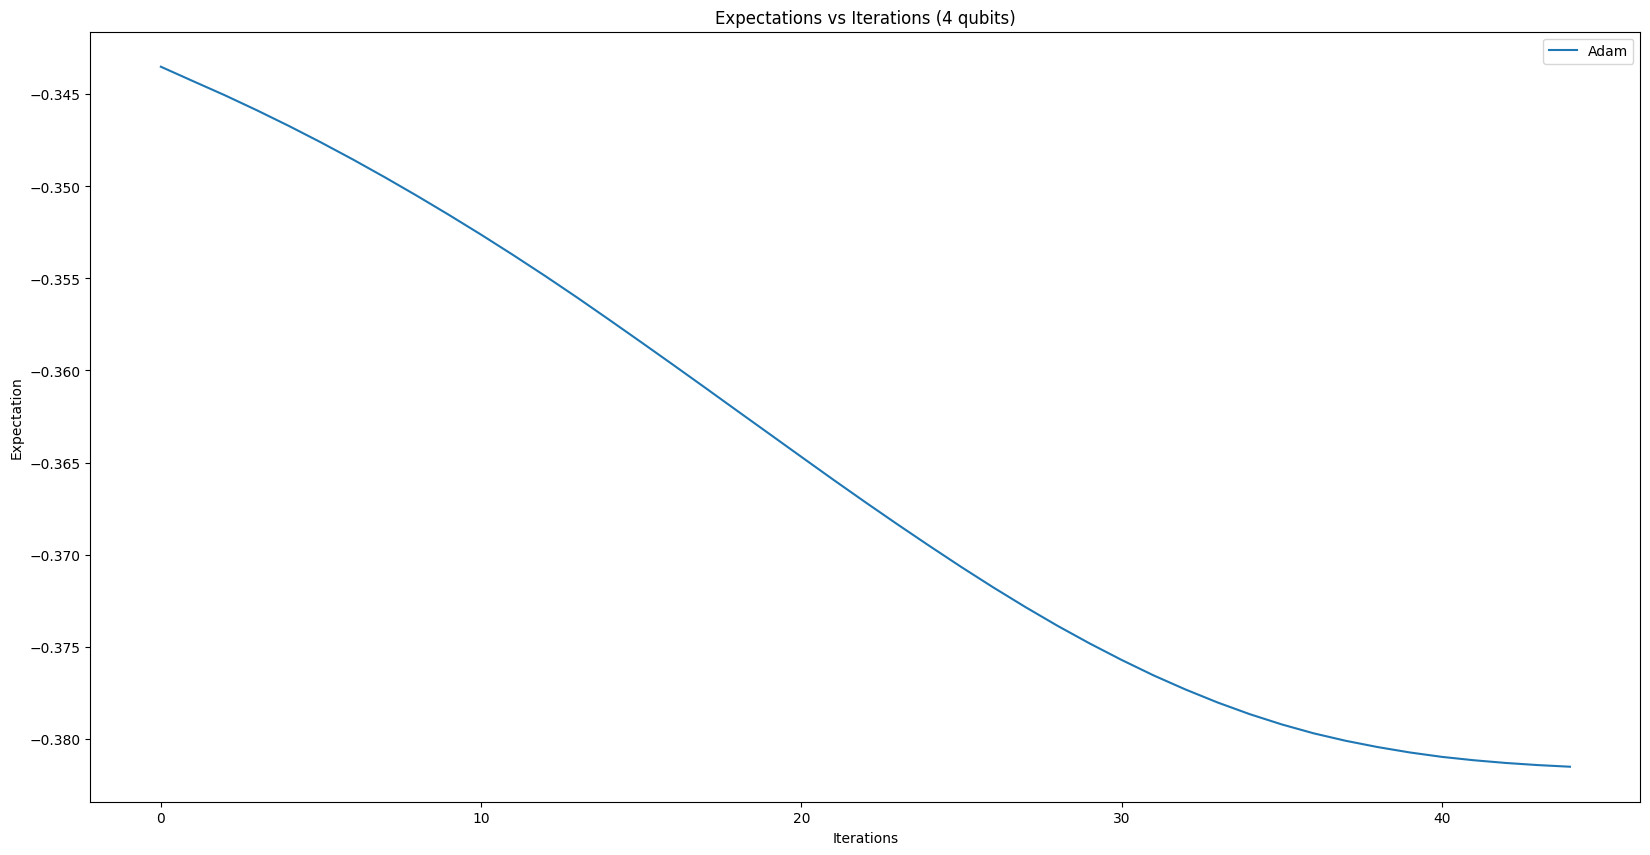

In [30]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()